# Module 2 Summative Lab

## Introduction

For today's section, we're going to work on a single big lab to apply everything we've learned in Module 2!

## About This Lab

A quick note before getting started--this lab isn't like other labs you seen so far. This lab is meant to take ~8 hours to complete, so it's much longer and more challenging that the average labs you've seen so far. If you feel like this lab is challenging or that you might be struggling a bit, don't fret--that's by design! With everything we've learned about Web Scraping, APIs, and Databases, the best way to test our knowledge of it is to build something substantial! 

## The Project

In this lab, we're going to make use of everything we've learned about APIs, databases, and Object-Oriented Programming to **_Extract, Transform, and Load_** (or **_ETL_**, for short) some data from a SQL database into a MongoDB Database. 

You'll find a database containing information about soccer teams and the matches they've played in the file `database.sqlite`. For this project, our goal is to get the data we think is important from this SQL database, do some calculations and data transformation, and then store everything in a MongoDB database. 

Let's get into the specifics of this project.

### The Goal

Start by examining the data dictionary for the SQL database we'll be working with, which comes from this [kaggle page](https://www.kaggle.com/laudanum/footballdelphi).  Familiarize yourself with the tables it contains, and what each column means. We'll be using this database to get data on each soccer team, calculate some summary statistics, and then store each in a MongoDB database. 

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

* The name of the team
* The total number of goals scored by the team during the 2011 season
* The total number of wins the team earned during the 2011 season
* A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
* The team's win percentage on days where it was raining during games in the 2011 season. 

#### Getting the Weather Data

Note that for this last calculation, you'll need to figure out if it was raining or not during the game. The database itself does not contain this information, but it does contain the date on which the game was played. For this, you'll need to use the [DarkSky API](https://darksky.net/dev) to get the historical weather data for that day. Note that each game is played in a different location, and this information is not contained in our SQL database. However, the teams in this database are largely german, so go ahead and just use the weather in Berlin, Germany as a proxy for this information. If it was raining in Berlin on the day the game was played, count that as rain game--**_you do not need to try and figure out the actual weather at each game's location, because we don't have that information!_**

#### NOTE: The DarkSky API is limited to 1000 free API calls a day, so be sure to test your model on very small samples. Otherwise, you'll hit the rate limit!

## Project Architecture

Unlike previous labs, this lab is more open-ended, and will require you to make design decisions and plan out your strategy for building a system with this many working parts. However, **_using Object-Oriented Programming is a requirement for this project--you must create at least 2 separate, well structured classes in your solution!_** Although it may seem easier to "just start coding", this is a classic beginner's mistake. Instead, think about separating out the different functionalities you'll need to reach your goal, and then build classes to handle each. For instance, at minimum, you'll need to:

* Query the SQL database
* Calculate summary statistics
* Get the weather data from the DarkSky API
* Load the data into MongoDB

We **_strongly recommend_** you consider creating separate classes for handling at least some of these of these tasks.  Be sure to plan the inputs, outputs, and methods for each class before you begin coding! 

**_NOTE:_** We have provided some empty classes below. You are welcome to delete them and use a different architecture for this project if you so choose.  You do not have to use each of them, they are just there to give you an idea of what you could sorts of classes you may want to consider using.

### Rapid Prototyping and Refactoring

It's totally okay to try to get a task working without using OOP. For instance, when experimenting with the DarkSky API for getting historical weather data, it makes sense to just write the code in the cells and rapidly iterate until you get it all working. However, once you get it working, you're not done--you should then **_Refactor_** your code into functions or classes to make your code more modular, reusable, understandable, and maintainable! 

In short--do what you need to do to get each separate piece of functionality working, and then refactor it into a class after you've figured it out!

### Some Final Advice

You haven't built anything this big or complex thus far, so you may not yet fully realize how much trial and error goes into it. If your code keeps breaking, resist the urge to get frustrated, and just keep working. Software development is an iterative process!  No one writes perfect code that works the first time for something this involved. You're going to run into _a lot_ of small errors in this project, right up until the point where it just works, and then you're done! However, you can reduce these errors by planning out your code, and thinking about how all of the pieces fit together before you begin coding. Once you have some basic understanding of how it all will work, then you'll know what you need to build, and then all that is left is to build it!

In short:

* Plan ahead--you'll thank yourself later!
* Errors and broken code aren't bad, they're normal. 
* Keep working, and stay confident--you can do this!

Good luck--we look forward to seeing your completed project!

## My project work: ##

In [890]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import json

import sqlite3
con = sqlite3.connect('database.sqlite')
cur = con.cursor()

<br>I did not have time to create classes, but I created several functions in Questions 5 that I reused for extracting and converting data from the API.

In [ ]:
# You don't have to use these classes, but we recommend them as a good place to start!
class WeatherGetter():
    pass

In [ ]:
class MongoHandler():
    pass

### Data exploration ###

Preview table 1: Unique Teams

In [136]:
query = """SELECT *
           FROM unique_teams
           """
ut = pd.read_sql_query(query, con)
display(ut.shape)
display(ut.head(3))

(128, 2)

,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2
2,Leverkusen,3


Preview table 2: Team in Matches

In [746]:
query = """SELECT *
           FROM Teams_in_matches
           """
tm = pd.read_sql_query(query, con)
display(tm.shape)
display(tm.head(3))

(49148, 2)

,Match_ID,Unique_Team_ID
0,1,26
1,1,46
2,2,26


Preview table 3: Matches

In [747]:
query = """SELECT *
           FROM Matches
           WHERE Season == 2011
           ORDER BY HomeTeam, Date
           """
m = pd.read_sql_query(query, con)
display(m.shape)
display(m.head(3))

(992, 9)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,A
1,1507,D2,2011,2011-08-13,Aachen,Cottbus,0,2,A
2,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D


In [140]:
# Get high-level total as a reference for checking after joining tables

query = """SELECT SUM(FTHG)+SUM(FTAG) Total_goals
           FROM Matches
           WHERE Season == 2011
           """
m_check = pd.read_sql_query(query, con)
m_check.head()

,Total_goals
0,2796


### Question 1 & 2: The name of the team & the total number of goals scored by team during the 2011 season ###

In [324]:
# Total goals per team
query = """SELECT ut.TeamName Team_name,
                  SUM(m.FTHG)+SUM(m.FTAG) Total_goals
           FROM unique_teams ut 
           JOIN matches m
                ON ut.TeamName = m.HomeTeam
           WHERE m.Season == 2011
           GROUP BY Team_name
           ORDER BY Team_name
           """    
df1 = pd.read_sql_query(query, con)

display(df1.shape)

# Check total goal matches original source
display(df1.Total_goals.sum())
display(df1)

(56, 2)

2796

,Team_name,Total_goals
0,Aachen,39
1,Arsenal,56
2,Aston Villa,45
3,Augsburg,39
4,Bayern Munich,55
5,Blackburn,59
6,Bochum,46
7,Bolton,62
8,Braunschweig,36
9,Chelsea,65


### Question 3: The total number of wins the team earned during the 2011 season ###

In [366]:
# Number of Wins

query = """ SELECT * FROM
                         (
                          SELECT CASE
                                      WHEN FTHG > FTAG THEN HomeTeam
                                      WHEN FTHG < FTAG THEN AwayTeam
                                      ELSE "Draw"
                                      END Team_name,
                                 COUNT(Match_ID) Num_of_wins
                          FROM Matches
                          WHERE Season == 2011
                          GROUP BY Team_name
                         )
                      WHERE Team_name != "Draw"
                      """
df3 = pd.read_sql_query(query, con)
display(df3.shape)
display(df3)

(56, 2)

,Team_name,Num_of_wins
0,Aachen,6
1,Arsenal,21
2,Aston Villa,7
3,Augsburg,8
4,Bayern Munich,23
5,Blackburn,8
6,Bochum,10
7,Bolton,10
8,Braunschweig,10
9,Chelsea,18


**Question 4: A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly by assigning it to a variable)**

In [365]:
# Number of Wins & Losses combined

query = """SELECT * FROM
                         (
                          SELECT t1.Team_name, t1.Num_of_wins, t2.Num_of_loss
                          FROM
                               (
                                SELECT CASE
                                            WHEN FTHG > FTAG THEN HomeTeam
                                            WHEN FTHG < FTAG THEN AwayTeam
                                            ELSE "Draw"
                                            END Team_name,
                                       COUNT(Match_ID) Num_of_wins
                                FROM Matches
                                WHERE Season == 2011
                                GROUP BY Team_name
                               )
                                t1
                          JOIN
                               (
                                SELECT CASE
                                            WHEN FTHG < FTAG THEN HomeTeam
                                            WHEN FTHG > FTAG THEN AwayTeam
                                            ELSE "Draw"
                                            END Team_name,
                                       COUNT(Match_ID) Num_of_loss
                                FROM Matches
                                WHERE Season == 2011
                                GROUP BY Team_name
                               )
                                t2
                          ON t1.Team_name = t2.Team_name
                         )
                     WHERE Team_name != "Draw"
                     """
df4 = pd.read_sql_query(query, con)
display(df4.shape)
display(df4)

(56, 3)

,Team_name,Num_of_wins,Num_of_loss
0,Aachen,6,15
1,Arsenal,21,10
2,Aston Villa,7,14
3,Augsburg,8,12
4,Bayern Munich,23,7
5,Blackburn,8,23
6,Bochum,10,17
7,Bolton,10,22
8,Braunschweig,10,9
9,Chelsea,18,10


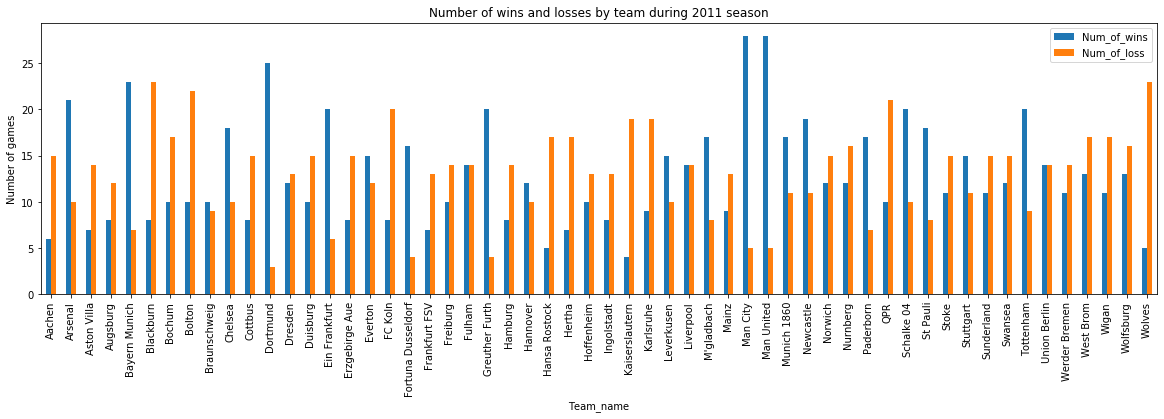

In [1001]:
fig = plt.figure(figsize=(20,5))
ax  = plt.subplot()
fig.add_axes(ax)

ax.set_title('Number of wins and losses by team during 2011 season')
ax.set_ylabel('Number of games')
df4.plot(x="Team_name", kind="bar", ax=ax)

### Question 5: The team's win percentage on days where it was raining during games in the 2011 season. ###

**Part 1: Explore and extract from DarkSky API:**

In [840]:
# Define functions to fetch data:

def get_keys(path):
    with open(path) as f:
        return json.load(f)
keys = get_keys("../darksky.json")
api_key = keys['api_key']

In [841]:
# Function to fetch data from Dark Sky

def getdarksky(lat,lon,time):
    link = f'https://api.darksky.net/forecast/{api_key}/{lat},{lon},{time}'
    r = requests.get(link)
    return r.json()

In [842]:
# Using Berlin coordinates as assumption for all locations

# Preview sample data from today

lat = 52.5200
lon = -13.4050
timeRecent = '2019-10-10T00:00:00Z'

sky = getdarksky(lat, lon, timeRecent)
sky

{'latitude': 52.52,
 'longitude': -13.405,
 'timezone': 'Etc/GMT+1',
 'currently': {'time': 1570665600,
  'summary': 'Mostly Cloudy',
  'icon': 'partly-cloudy-night',
  'precipIntensity': 0.0004,
  'precipProbability': 0.07,
  'precipType': 'rain',
  'temperature': 54.82,
  'apparentTemperature': 54.82,
  'dewPoint': 46.02,
  'humidity': 0.72,
  'pressure': 1009.3,
  'windSpeed': 22.19,
  'windGust': 25.99,
  'windBearing': 250,
  'cloudCover': 0.66,
  'uvIndex': 0,
  'visibility': 10,
  'ozone': 269.7},
 'hourly': {'summary': 'Possible light rain overnight and in the morning.',
  'icon': 'rain',
  'data': [{'time': 1570582800,
    'summary': 'Windy and Mostly Cloudy',
    'icon': 'wind',
    'precipIntensity': 0.0038,
    'precipProbability': 0.16,
    'precipType': 'rain',
    'temperature': 53.23,
    'apparentTemperature': 53.23,
    'dewPoint': 43.82,
    'humidity': 0.7,
    'pressure': 1005.8,
    'windSpeed': 29.1,
    'windGust': 34.6,
    'windBearing': 279,
    'cloudCover':

In [843]:
sky.keys()

dict_keys(['latitude', 'longitude', 'timezone', 'currently', 'hourly', 'daily', 'flags', 'offset'])

In [844]:
sky['currently'].keys()

dict_keys(['time', 'summary', 'icon', 'precipIntensity', 'precipProbability', 'precipType', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'ozone'])

In [845]:
len(sky['currently'].keys())

18

In [846]:
weather_type = sky['currently']['precipType']
weather_type

'rain'

In [847]:
# Get dates of all matches from SQL

query = """SELECT DISTINCT Date
           FROM Matches
           WHERE Season == 2011
           ORDER BY Date
           """
matchdates = pd.read_sql_query(query, con)
display(matchdates.shape)
display(matchdates.dtypes)


(165, 1)

Date    object
dtype: object

In [848]:
matchdates['Darksky_date'] = matchdates['Date'].map(lambda x: f'{x}T00:00:00Z')
display(matchdates.head(3))
display(matchdates.tail(3))


,Date,Darksky_date
0,2011-07-15,2011-07-15T00:00:00Z
1,2011-07-16,2011-07-16T00:00:00Z
2,2011-07-17,2011-07-17T00:00:00Z


,Date,Darksky_date
162,2012-05-07,2012-05-07T00:00:00Z
163,2012-05-08,2012-05-08T00:00:00Z
164,2012-05-13,2012-05-13T00:00:00Z


In [849]:
# Limit number of dates first for testing

testdates = list(matchdates.Darksky_date[0:10])
berlin_lat = 52.5200
berlin_lon = -13.4050

In [850]:
# Function to extract rain information from multiple dates

def darksky_rain_info(lat, lon, list_of_dates):
    
    precipTypeList = []
    
    for date in list_of_dates:
        link = f'https://api.darksky.net/forecast/{api_key}/{lat},{lon},{date}'
        r = requests.get(link)
        skydata = r.json()
        if len(skydata) >= 8:
            precipType = skydata['currently']['icon']
        else:
            precipType = f'No data. Status={r.status_code}'
        precipTypeList.append(precipType)
        
    precipTypeInfo = {}
    
    for i in range(len(list_of_dates)):
        precipTypeInfo[list_of_dates[i]] = precipTypeList[i]    
            
    return precipTypeInfo


In [781]:
# Run rain info with test data

# darksky_rain_info(berlin_lat, berlin_lon, testdates)


{'2011-07-15T00:00:00Z': 'No info',
 '2011-07-16T00:00:00Z': 'No info',
 '2011-07-17T00:00:00Z': 'No info',
 '2011-07-18T00:00:00Z': 'No info',
 '2011-07-22T00:00:00Z': 'No info',
 '2011-07-23T00:00:00Z': 'No info',
 '2011-07-24T00:00:00Z': 'No info',
 '2011-07-25T00:00:00Z': 'No info',
 '2011-08-05T00:00:00Z': 'No info',
 '2011-08-06T00:00:00Z': 'No info'}

**Note:**<br>
For some unexplained reason, DarkSky data is not available to me when the dates are **older than the past 1 year**. Data older than 12-12-2018 gives out an OK status=200 but the json output has no data inside them. <br><br>
To confirm that this is an API issue instead of my Python codes, I tested this directly on the browser to bypass any coding and still get the same the result. Here's a sample when I entered 2011 data (as per the league table dates):

In [851]:
# Preview sample data from 2011 - Note that generated data is incomplete.
# I got the same missing data when keyed in directly into the browser at
# https://api.darksky.net/forecast/e03e59714456ab18516c672f47df1166/52.52,-13.405,2011-07-15T00:00:00

time2011 = '2011-07-15T00:00:00Z'

sky2011 = getdarksky(berlin_lat, berlin_lon, time2011)
sky2011

{'latitude': 52.52,
 'longitude': -13.405,
 'timezone': 'Etc/GMT+1',
 'currently': {'time': 1310688000, 'uvIndex': 0},
 'flags': {'sources': ['cmc', 'gfs', 'icon', 'isd', 'madis'], 'units': 'us'},
 'offset': -1}

Now to demonstrate that there is no data if I go back to dates **older than 1 year ago** before and after 12-12-2018:

In [852]:
# Using 8 dates between 2018-12-08 and 2018-12-15:

testdates2 = ['2018-12-08T00:00:00Z', '2018-12-09T00:00:00Z', '2018-12-10T00:00:00Z', '2018-12-11T00:00:00Z',
              '2018-12-12T00:00:00Z', '2018-12-13T00:00:00Z', '2018-12-14T00:00:00Z', '2018-12-15T00:00:00Z',
              '2018-12-16T00:00:00Z', '2018-12-17T00:00:00Z']

darkskytest2018 = darksky_rain_info(berlin_lat, berlin_lon, testdates2)
darkskytest2018

{'2018-12-08T00:00:00Z': 'No data. Status=200',
 '2018-12-09T00:00:00Z': 'No data. Status=200',
 '2018-12-10T00:00:00Z': 'No data. Status=200',
 '2018-12-11T00:00:00Z': 'No data. Status=200',
 '2018-12-12T00:00:00Z': 'No data. Status=200',
 '2018-12-13T00:00:00Z': 'partly-cloudy-night',
 '2018-12-14T00:00:00Z': 'partly-cloudy-night',
 '2018-12-15T00:00:00Z': 'partly-cloudy-night',
 '2018-12-16T00:00:00Z': 'wind',
 '2018-12-17T00:00:00Z': 'wind'}

For the purpose of this exercise, since I only have for the past 1 year, I'm going to **restate 2011/2012 to be 2019** dates where API data is available:
<br><br>

In [859]:
# Restating 2011/2012 dates into 2019 dates so that we can move on:
# input in yyyy-mm-dd (with dash)

def convert2019date(yyyymmdd):
    
    date_year  = yyyymmdd[0:4]
    date_month = yyyymmdd[5:7]
    date_day   = yyyymmdd[8:11]

    new_year   = 2019 
    
    temp_month = int(yyyymmdd[5:7]) - 6 if int(yyyymmdd[5:7]) > 6 else int(yyyymmdd[5:7]) + 6

    new_month  = '0' + str(temp_month) if temp_month < 10 else temp_month

    return f'{new_year}-{new_month}-{date_day}T00:00:00Z'

matchdates['Darksky_date'] = matchdates['Date'].map(convert2019date)

matchdates

,Date,Darksky_date
0,2011-07-15,2019-01-15T00:00:00Z
1,2011-07-16,2019-01-16T00:00:00Z
2,2011-07-17,2019-01-17T00:00:00Z
3,2011-07-18,2019-01-18T00:00:00Z
4,2011-07-22,2019-01-22T00:00:00Z
...,...,...
160,2012-05-05,2019-11-05T00:00:00Z
161,2012-05-06,2019-11-06T00:00:00Z
162,2012-05-07,2019-11-07T00:00:00Z
163,2012-05-08,2019-11-08T00:00:00Z


In [860]:
# Now test if API data is available for the restated dates:

testdates2019 = list(matchdates.Darksky_date[0:5])

darkskytest2019 = darksky_rain_info(berlin_lat, berlin_lon, testdates2019)
darkskytest2019

{'2019-01-15T00:00:00Z': 'cloudy',
 '2019-01-16T00:00:00Z': 'cloudy',
 '2019-01-17T00:00:00Z': 'partly-cloudy-night',
 '2019-01-18T00:00:00Z': 'wind',
 '2019-01-22T00:00:00Z': 'wind'}

In [861]:
# Fetch DarkSky with all dates

searchdates = list(matchdates.Darksky_date)

berlin_rain_dict = darksky_rain_info(berlin_lat, berlin_lon, searchdates)
berlin_rain_dict


{'2019-01-15T00:00:00Z': 'cloudy',
 '2019-01-16T00:00:00Z': 'cloudy',
 '2019-01-17T00:00:00Z': 'partly-cloudy-night',
 '2019-01-18T00:00:00Z': 'wind',
 '2019-01-22T00:00:00Z': 'wind',
 '2019-01-23T00:00:00Z': 'cloudy',
 '2019-01-24T00:00:00Z': 'wind',
 '2019-01-25T00:00:00Z': 'partly-cloudy-night',
 '2019-02-05T00:00:00Z': 'rain',
 '2019-02-06T00:00:00Z': 'wind',
 '2019-02-07T00:00:00Z': 'wind',
 '2019-02-08T00:00:00Z': 'rain',
 '2019-02-12T00:00:00Z': 'wind',
 '2019-02-13T00:00:00Z': 'wind',
 '2019-02-14T00:00:00Z': 'cloudy',
 '2019-02-15T00:00:00Z': 'wind',
 '2019-02-19T00:00:00Z': 'cloudy',
 '2019-02-20T00:00:00Z': 'rain',
 '2019-02-21T00:00:00Z': 'wind',
 '2019-02-22T00:00:00Z': 'wind',
 '2019-02-26T00:00:00Z': 'cloudy',
 '2019-02-27T00:00:00Z': 'cloudy',
 '2019-02-28T00:00:00Z': 'partly-cloudy-night',
 '2019-02-29T00:00:00Z': 'No data. Status=400',
 '2019-03-09T00:00:00Z': 'wind',
 '2019-03-10T00:00:00Z': 'rain',
 '2019-03-11T00:00:00Z': 'wind',
 '2019-03-12T00:00:00Z': 'wind',
 '

In [862]:
# Move to data frame

rain_df = pd.DataFrame(list(berlin_rain_dict.values()), index=list(berlin_rain_dict.keys()))
rain_df = rain_df.rename(columns={0 : "Weather"})
rain_df

,Weather
2019-01-15T00:00:00Z,cloudy
2019-01-16T00:00:00Z,cloudy
2019-01-17T00:00:00Z,partly-cloudy-night
2019-01-18T00:00:00Z,wind
2019-01-22T00:00:00Z,wind
...,...
2019-11-05T00:00:00Z,wind
2019-11-06T00:00:00Z,cloudy
2019-11-07T00:00:00Z,wind
2019-11-08T00:00:00Z,partly-cloudy-night


**Part 2: Analyze team performance based on weather conditions:**

In [930]:
# Return to SQL table Match

query = """SELECT *
           FROM Matches
           WHERE Season == 2011
           ORDER BY HomeTeam, Date
           """
df = pd.read_sql_query(query, con)
display(df.shape)

# Include WEATHER information to Match table

df['Darksky_date'] = df['Date'].map(convert2019date)
df = df.set_index('Darksky_date')
df = df.join(rain_df)
df = df.reset_index()
df = df.drop(columns='index')

display(df.shape)

display(df.iloc[11:18])

(992, 9)

(992, 10)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Weather
11,1596,D2,2011,2011-07-22,Ingolstadt,Erzgebirge Aue,0,0,D,wind
12,1261,D2,2011,2011-07-23,Munich 1860,Karlsruhe,2,1,H,cloudy
13,1525,D2,2011,2011-07-23,Union Berlin,Greuther Furth,0,4,A,cloudy
14,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,A,wind
15,1390,D2,2011,2011-07-24,Dresden,Hansa Rostock,1,1,D,wind
16,1699,D2,2011,2011-07-24,Paderborn,Fortuna Dusseldorf,1,1,D,wind
17,1463,D2,2011,2011-07-25,Ein Frankfurt,St Pauli,1,1,D,partly-cloudy-night


In [931]:
# Explore types of weather by num of match day

df_chk1 = df.drop_duplicates(['Date','Weather'])[['Date','Weather']]
df_chk1.Weather.value_counts()

partly-cloudy-night    58
wind                   42
cloudy                 31
rain                   15
clear-night            15
No data. Status=400     4
Name: Weather, dtype: int64

In [962]:
# Filter to see rainy days only, exclude draws

df_rain = df.loc[(df['Weather'] == 'rain') & (df['FTR'] != 'D'),
                ['HomeTeam', 'AwayTeam', 'FTR', 'Weather']]

# Pick winner only

df_rain['Win_rain'] = df_rain.apply(lambda row: row['HomeTeam'] if row['FTR'] == 'H' else row['AwayTeam'], axis=1)

df_rain_win = pd.DataFrame(df_rain.Win_rain.value_counts())
df_rain_win.head()

,Win_rain
Dortmund,4
Arsenal,4
Bayern Munich,4
Union Berlin,3
Greuther Furth,3


In [963]:
# Back to the previous wins & losses table from Question 4

df4.head()

,Team_name,Num_of_wins,Num_of_loss
0,Aachen,6,15
1,Arsenal,21,10
2,Aston Villa,7,14
3,Augsburg,8,12
4,Bayern Munich,23,7


In [996]:
# Join Win statistics with Weather information

df5 = df4
df5 = df5.set_index('Team_name')
df5 = df4.join(df_rain_win, on = 'Team_name')
df5['Win_rain'] = df5['Win_rain'].fillna(0)
df5['Win_rain'] = df5['Win_rain'].astype(int)
df5 = df5.drop(columns = ['Num_of_loss'])
df5

# Calculate the % winning games per team when it rains

df5['Rain_win_rate'] = df5['Win_rain'] / df5['Num_of_wins']
df5_sort = df5.sort_values(by = 'Rain_win_rate', ascending = False)
df5_sort

# Note that the percentages below will be different from other students
# since I am using Jan-Dec 2019 data as an assumption


,Team_name,Num_of_wins,Win_rain,Rain_win_rate
27,Hoffenheim,10,3,0.300000
26,Hertha,7,2,0.285714
51,Werder Bremen,11,3,0.272727
29,Kaiserslautern,4,1,0.250000
12,Dresden,12,3,0.250000
50,Union Berlin,14,3,0.214286
55,Wolves,5,1,0.200000
25,Hansa Rostock,5,1,0.200000
1,Arsenal,21,4,0.190476
18,Fortuna Dusseldorf,16,3,0.187500


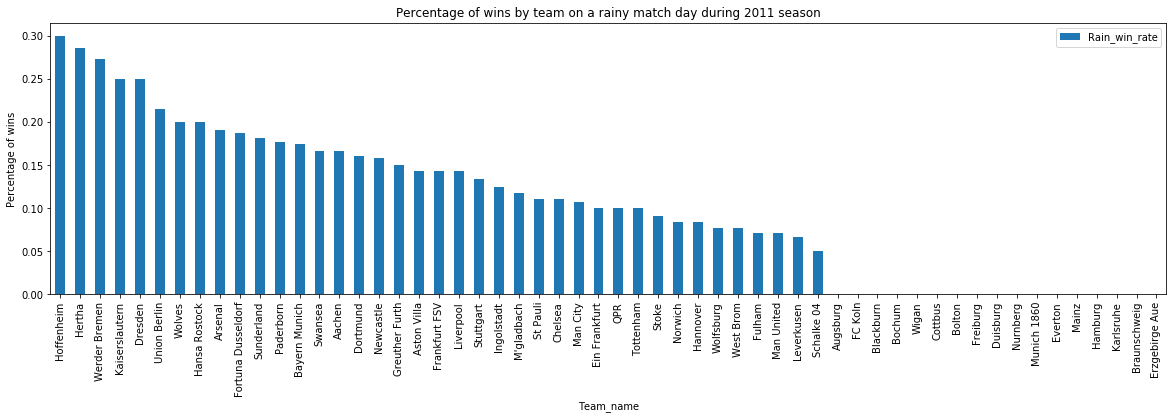

In [1002]:
fig = plt.figure(figsize=(20,5))
ax  = plt.subplot()
fig.add_axes(ax)

ax.set_title('Percentage of wins by team on a rainy match day during 2011 season')
ax.set_ylabel('Percentage of wins')
df5_sort.plot(x="Team_name", y="Rain_win_rate", kind="bar", ax=ax)

# Summary

In this lab, we dug deep and used everything we've learned so far about python programming, databases, HTTP requests and API calls to ETL data from a SQL database into a MongoDB instance!